In [1]:
import pandas as pd

data = pd.read_parquet("output/predictions_deepseek_chat.parquet")

In [2]:
data = data.merge(
    data.groupby(["vote_id", "party"])
    .size()
    .reset_index(name="count")
    .drop_duplicates("vote_id")
    .drop(columns="party"),
    on="vote_id",
    how="left",
).rename(columns={"count": "beschlussempfehlung_drucksachen"})

data = data[[
    "type",
    "beschlussempfehlung",
    "proposers",
    "party",
    "prediction",
    "category",
    "is_governing",
    "bundestag",
    "is_own_proposal",
    "beschlussempfehlung_drucksachen",
    "ground_truth",
]]

proposers = pd.DataFrame(data["proposers"].apply(
    lambda li: {p: True for p in li}
).tolist()).fillna(False)
proposers.columns = [
    f"proposer_{p}" for p in proposers.columns
]
data = pd.concat([data, proposers], axis=1)
data.drop(columns=["proposers"], inplace=True)
data = pd.get_dummies(
    data,
    columns=["type", "prediction", "beschlussempfehlung", "party", "category"]
)

C:\Users\johnn\AppData\Local\Temp\ipykernel_33488\25892648.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).tolist()).fillna(False)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

y = data.pop("ground_truth")
X_train, X_test, y_train, y_test = train_test_split(
    data, y, test_size=0.2, random_state=42, stratify=y
)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)


model = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

model.fit(X_train, y_train_enc)

y_pred_enc = model.predict(X_test)
y_pred = le.inverse_transform(y_pred_enc)

e:\Users\johnn\anaconda3\envs\langchain\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:45:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.8658008658008658

Classification Report:
              precision    recall  f1-score   support

   Ablehnung       0.86      0.93      0.90       344
     Annahme       0.92      0.88      0.90       309
  Enthaltung       0.30      0.17      0.22        40

    accuracy                           0.87       693
   macro avg       0.69      0.66      0.67       693
weighted avg       0.85      0.87      0.86       693


Confusion Matrix:
[[321  15   8]
 [ 29 272   8]
 [ 23  10   7]]


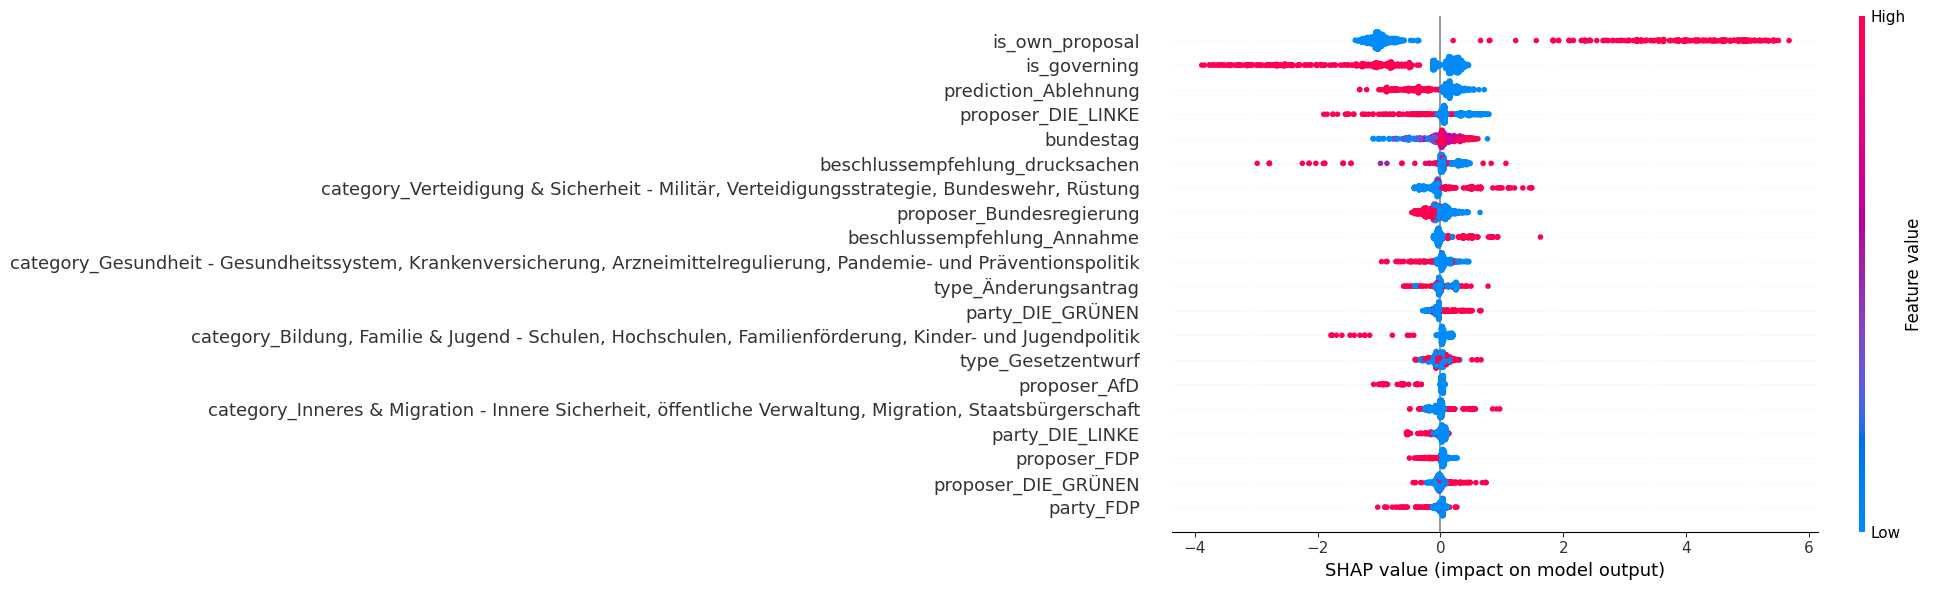

In [15]:
import shap
from matplotlib import pyplot as plt
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[:,:,1], X_test, plot_size=(20, 6))